<a href="https://colab.research.google.com/github/Shub2204/LJMU_Research_Thesis/blob/main/Banana_Disease_Detetction_using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Extracting Zipped File

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
zip_path = "/content/drive/MyDrive/LJMU_Research/Dataset_Code_Experiment/BLD_Dataset.zip"

In [ ]:
import zipfile
import os

# Define the extraction path
extract_path = "/content/drive/MyDrive/LJMU_Research/Dataset_Code_Experiment/train"

# Create the directory if it doesn't exist
os.makedirs(extract_path, exist_ok=True)

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Files extracted to: {extract_path}")

Files extracted to: /content/drive/MyDrive/LJMU_Research/Dataset_Code_Experiment/train


## Importing Libraries

In [4]:
!pip install mahotas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 67.0 MB/s eta 0:00:00


In [5]:
## IMPORTING LIBRARIES
import os
import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import mahotas  # For NGTDM feature extraction
import pickle

from PIL import Image
from google.colab import drive
from tqdm import tqdm
from skimage.filters import threshold_otsu
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, f1_score, average_precision_score, roc_auc_score
from sklearn.preprocessing import label_binarize, StandardScaler
from google.colab import drive
from skimage.feature import graycomatrix, graycoprops  # For GLCM functions
from sklearn.svm import SVC
from sklearn.decomposition import PCA

## Verifying Datasets

In [1]:
# Path to your dataset inside Google Drive
base_dir = "/content/drive/MyDrive/LJMU_Research/Dataset_Code_Experiment/train/BLD_Dataset"

# Verify the dataset path
if not os.path.exists(base_dir):
    print("Error: Dataset path does not exist. Check your Google Drive path!")
else:
    # List all subfolders (each representing a disease class)
    disease_classes = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
    print("Found Classes:", disease_classes)

    # Loop over each disease folder
    for disease_class in disease_classes:
        class_path = os.path.join(base_dir, disease_class)
        image_files = os.listdir(class_path)

        print(f"\nProcessing Class: {disease_class}")
        print(f"Number of images: {len(image_files)}")

        # Loop over each image in the disease folder
        for img_name in image_files:
            img_path = os.path.join(class_path, img_name)

            # Read the image (OpenCV reads in BGR format)
            img = cv2.imread(img_path)

            if img is not None:
                # Example: print shape to confirm successful load
                print(f"  - {img_name} | shape: {img.shape}")
            else:
                print(f"  - Could not read {img_name}")

Streaming output truncated to the last 5000 lines.
  - aug_0_4821.jpg | shape: (256, 256, 3)
  - aug_0_4844.jpg | shape: (256, 256, 3)
  - aug_0_4856.jpg | shape: (256, 256, 3)
  - aug_0_4897.jpg | shape: (256, 256, 3)
  - aug_0_49.jpg | shape: (256, 256, 3)
  - aug_0_4918.jpg | shape: (256, 256, 3)
  - aug_0_4919.jpg | shape: (256, 256, 3)
  - aug_0_4920.jpg | shape: (256, 256, 3)
  - aug_0_4924.jpg | shape: (256, 256, 3)
  - aug_0_4971.jpg | shape: (256, 256, 3)
  - aug_0_4981.jpg | shape: (256, 256, 3)
  - aug_0_5030.jpg | shape: (256, 256, 3)
  - aug_0_5058.jpg | shape: (256, 256, 3)
  - aug_0_506.jpg | shape: (256, 256, 3)
  - aug_0_5068.jpg | shape: (256, 256, 3)
  - aug_0_5076.jpg | shape: (256, 256, 3)
  - aug_0_5095.jpg | shape: (256, 256, 3)
  - aug_0_5118.jpg | shape: (256, 256, 3)
  - aug_0_5181.jpg | shape: (256, 256, 3)
  - aug_0_5190.jpg | shape: (256, 256, 3)
  - aug_0_5193.jpg | shape: (256, 256, 3)
  - aug_0_5214.jpg | shape: (256, 256, 3)
  - aug_0_5227.jpg | shape: 

## Resizing Image Datasets to 224*224

In [2]:
# Set base directories (Change paths as needed)
base_dir = "/content/drive/MyDrive/LJMU_Research/Dataset_Code_Experiment/train/BLD_Dataset"
resized_dir = "/content/drive/MyDrive/LJMU_Research/Dataset_Code_Experiment/train/BLD_Resized_Dataset"  # Folder to save resized images

# Create the resized dataset directory if it doesn't exist
os.makedirs(resized_dir, exist_ok=True)

# List all disease classes
disease_classes = os.listdir(base_dir)
print("Found Classes:", disease_classes)

# Function to apply aspect ratio-preserving padding
def resize_with_padding(image, target_size=224):
    h, w, c = image.shape  # Get original dimensions

    # Calculate padding (if needed)
    pad_top = pad_bottom = pad_left = pad_right = 0

    if h < target_size or w < target_size:
        # Calculate how much padding is needed to make the image square
        max_dim = max(h, w)
        pad_top = (max_dim - h) // 2
        pad_bottom = max_dim - h - pad_top
        pad_left = (max_dim - w) // 2
        pad_right = max_dim - w - pad_left

        # Add padding with black (zero pixels)
        image = cv2.copyMakeBorder(image, pad_top, pad_bottom, pad_left, pad_right,
                                   cv2.BORDER_CONSTANT, value=(0, 0, 0))  # Black padding

    # Resize the padded image to 224x224
    resized_image = cv2.resize(image, (target_size, target_size), interpolation=cv2.INTER_AREA)
    return resized_image

# Loop through each disease class and resize images
for disease_class in disease_classes:
    class_path = os.path.join(base_dir, disease_class)

    if os.path.isdir(class_path):
        save_class_path = os.path.join(resized_dir, disease_class)
        os.makedirs(save_class_path, exist_ok=True)

        image_files = os.listdir(class_path)
        print(f"\nProcessing Class: {disease_class}, Total images: {len(image_files)}")

        for img_name in tqdm(image_files):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)

            if img is not None:
                resized_img = resize_with_padding(img)  # Apply aspect-ratio-preserving padding & resizing

                # Save the resized image
                save_path = os.path.join(save_class_path, img_name)
                cv2.imwrite(save_path, resized_img)
            else:
                print(f"Warning: Could not read {img_name}")

Found Classes: ['Aphids', 'Black_Singatoka', 'Bract_Mosaic', 'Cordana', 'Fusarium_Wilt', 'healthy', 'Insect_Pest', 'Moko', 'Pestalotiopsis', 'Pseudostem_Weevil', 'Scarring_Beetle', 'Soft_Rot', 'Xamthomonas', 'Yellow_Singatoka']

Processing Class: Aphids, Total images: 520


100%|██████████| 520/520 [00:09<00:00, 52.92it/s]



Processing Class: Black_Singatoka, Total images: 865


100%|██████████| 865/865 [00:33<00:00, 25.86it/s]



Processing Class: Bract_Mosaic, Total images: 585


100%|██████████| 585/585 [00:10<00:00, 54.93it/s]



Processing Class: Cordana, Total images: 795


100%|██████████| 795/795 [00:15<00:00, 52.54it/s]



Processing Class: Fusarium_Wilt, Total images: 844


100%|██████████| 844/844 [00:30<00:00, 28.06it/s]



Processing Class: healthy, Total images: 769


100%|██████████| 769/769 [00:14<00:00, 52.61it/s]



Processing Class: Insect_Pest, Total images: 589


100%|██████████| 589/589 [00:12<00:00, 48.82it/s]



Processing Class: Moko, Total images: 648


100%|██████████| 648/648 [00:13<00:00, 49.11it/s]



Processing Class: Pestalotiopsis, Total images: 841


100%|██████████| 841/841 [00:17<00:00, 48.41it/s]



Processing Class: Pseudostem_Weevil, Total images: 811


100%|██████████| 811/811 [00:17<00:00, 46.61it/s]



Processing Class: Scarring_Beetle, Total images: 626


100%|██████████| 626/626 [00:13<00:00, 47.44it/s]



Processing Class: Soft_Rot, Total images: 987


100%|██████████| 987/987 [00:22<00:00, 44.42it/s]



Processing Class: Xamthomonas, Total images: 801


100%|██████████| 801/801 [00:16<00:00, 48.47it/s]



Processing Class: Yellow_Singatoka, Total images: 500


100%|██████████| 500/500 [00:09<00:00, 53.43it/s]


## Preprocessing Images

In [3]:
# Set paths to your dataset folders on Google Drive
resized_dir = "/content/drive/MyDrive/LJMU_Research/Dataset_Code_Experiment/train/BLD_Resized_Dataset"  # Folder with resized images (e.g., 224×224)
preprocessed_dir = "/content/drive/MyDrive/LJMU_Research/Dataset_Code_Experiment/train/BLD_Preprocessed_Dataset"  # Folder to save preprocessed images

os.makedirs(preprocessed_dir, exist_ok=True)

def advanced_preprocess(img, to_grayscale=False, gaussian_kernel=5, apply_otsu=False, normalize=True):
    """
    Perform optional grayscale conversion, Gaussian blur, Otsu's thresholding,
    and normalization on an input image.
    """
    processed_img = img.copy()

    # 1. Convert to Grayscale (Optional)
    if to_grayscale:
        processed_img = cv2.cvtColor(processed_img, cv2.COLOR_BGR2GRAY)
        # Stack to retain 3 channels for consistent shape
        processed_img = np.stack([processed_img] * 3, axis=-1)

    # 2. Apply Gaussian Blur (Noise Reduction)
    processed_img = cv2.GaussianBlur(processed_img, (gaussian_kernel, gaussian_kernel), 0)

    # 3. Otsu’s Thresholding for Background Removal (Optional)
    if apply_otsu:
        gray_for_otsu = cv2.cvtColor(processed_img, cv2.COLOR_BGR2GRAY)
        thresh_val = threshold_otsu(gray_for_otsu)
        mask = (gray_for_otsu > thresh_val).astype(np.uint8)
        # Zero-out the background (mask == 0)
        processed_img[mask == 0] = 0

    # 4. Normalize pixel values to [0, 1]
    if normalize:
        processed_img = processed_img.astype(np.float32) / 255.0

    return processed_img

# Process each disease class folder in the resized dataset
disease_classes = os.listdir(resized_dir)
print("Found Classes:", disease_classes)

for disease_class in disease_classes:
    class_path = os.path.join(resized_dir, disease_class)

    if os.path.isdir(class_path):
        # Create corresponding folder in the preprocessed directory
        save_class_path = os.path.join(preprocessed_dir, disease_class)
        os.makedirs(save_class_path, exist_ok=True)

        image_files = os.listdir(class_path)
        print(f"\nPreprocessing Class: {disease_class}, Images: {len(image_files)}")

        for img_name in tqdm(image_files):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)

            if img is not None:
                # Apply advanced preprocessing with chosen parameters
                processed_img = advanced_preprocess(
                    img,
                    to_grayscale=True,    # Convert image to grayscale (and stack to 3 channels)
                    gaussian_kernel=5,    # Kernel size for Gaussian blur
                    apply_otsu=True,      # Apply Otsu's thresholding for background removal
                    normalize=True        # Normalize the pixel values
                )

                # Convert back to uint8 (if saving to disk as image)
                saved_img = (processed_img * 255).astype(np.uint8)
                save_path = os.path.join(save_class_path, img_name)
                cv2.imwrite(save_path, saved_img)
            else:
                print(f"Could not read {img_name}")

Found Classes: ['Aphids', 'Black_Singatoka', 'Bract_Mosaic', 'Cordana', 'Fusarium_Wilt', 'healthy', 'Insect_Pest', 'Moko', 'Pestalotiopsis', 'Pseudostem_Weevil', 'Scarring_Beetle', 'Soft_Rot', 'Xamthomonas', 'Yellow_Singatoka']

Preprocessing Class: Aphids, Images: 520


100%|██████████| 520/520 [00:10<00:00, 48.85it/s]



Preprocessing Class: Black_Singatoka, Images: 865


100%|██████████| 865/865 [00:20<00:00, 42.29it/s]



Preprocessing Class: Bract_Mosaic, Images: 585


100%|██████████| 585/585 [00:12<00:00, 45.63it/s]



Preprocessing Class: Cordana, Images: 795


100%|██████████| 795/795 [00:17<00:00, 44.80it/s]



Preprocessing Class: Fusarium_Wilt, Images: 844


100%|██████████| 844/844 [00:19<00:00, 44.29it/s]



Preprocessing Class: healthy, Images: 769


100%|██████████| 769/769 [00:15<00:00, 48.34it/s]



Preprocessing Class: Insect_Pest, Images: 589


100%|██████████| 589/589 [00:12<00:00, 47.04it/s]



Preprocessing Class: Moko, Images: 648


100%|██████████| 648/648 [00:13<00:00, 47.23it/s]



Preprocessing Class: Pestalotiopsis, Images: 841


100%|██████████| 841/841 [00:18<00:00, 45.57it/s]



Preprocessing Class: Pseudostem_Weevil, Images: 811


100%|██████████| 811/811 [00:18<00:00, 44.56it/s]



Preprocessing Class: Scarring_Beetle, Images: 626


100%|██████████| 626/626 [00:13<00:00, 45.87it/s]



Preprocessing Class: Soft_Rot, Images: 987


100%|██████████| 987/987 [00:21<00:00, 45.04it/s]



Preprocessing Class: Xamthomonas, Images: 801


100%|██████████| 801/801 [00:16<00:00, 48.30it/s]



Preprocessing Class: Yellow_Singatoka, Images: 500


100%|██████████| 500/500 [00:10<00:00, 48.29it/s]


## Exploratory Data Analysis

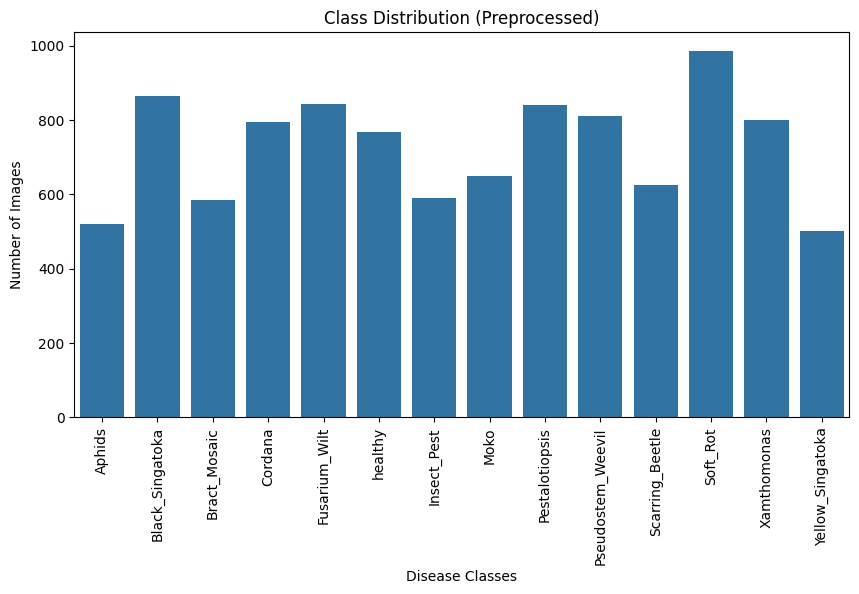

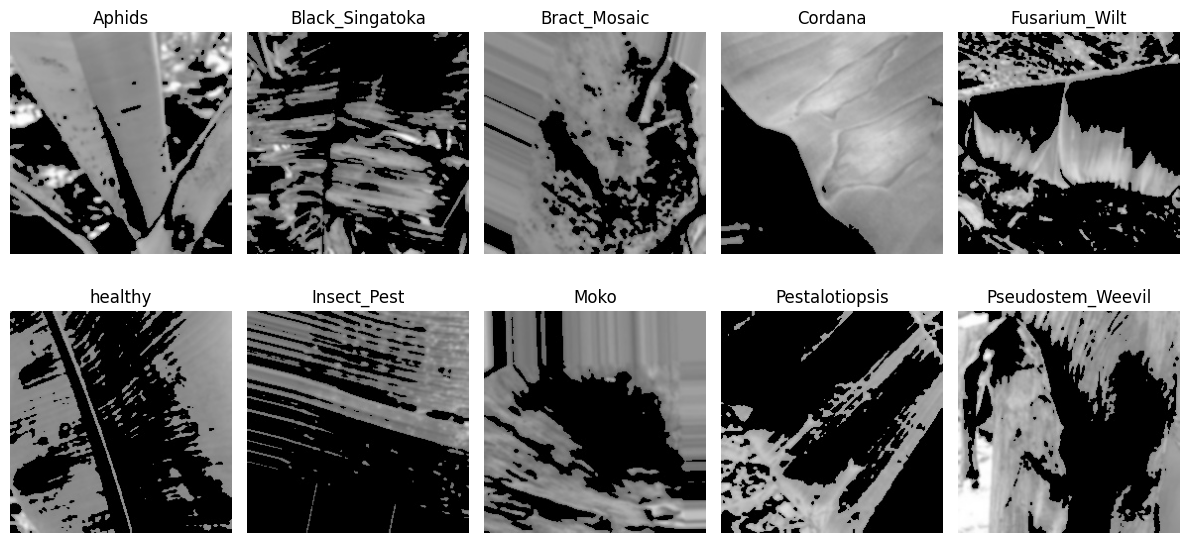

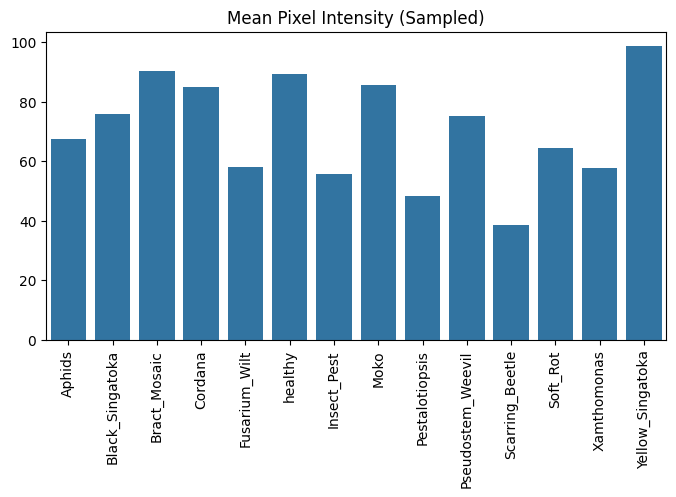

In [4]:
# Set base_dir to your preprocessed dataset path in Google Drive
base_dir = "/content/drive/MyDrive/LJMU_Research/Dataset_Code_Experiment/train/BLD_Preprocessed_Dataset"

# 1. Class distribution
disease_classes = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
class_counts = {}
for disease_class in disease_classes:
    class_path = os.path.join(base_dir, disease_class)
    image_files = os.listdir(class_path)
    class_counts[disease_class] = len(image_files)

plt.figure(figsize=(10, 5))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.xticks(rotation=90)
plt.xlabel("Disease Classes")
plt.ylabel("Number of Images")
plt.title("Class Distribution (Preprocessed)")
plt.show()

# 2. Show sample images per class (display first image from first 10 classes)
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
axes = axes.ravel()
for i, disease_class in enumerate(disease_classes[:10]):
    class_path = os.path.join(base_dir, disease_class)
    image_files = os.listdir(class_path)
    if len(image_files) > 0:
        img_path = os.path.join(class_path, image_files[0])
        img = Image.open(img_path)
        axes[i].imshow(img)
        axes[i].set_title(disease_class)
        axes[i].axis("off")
plt.tight_layout()
plt.show()

# 3. Mean pixel intensities (sample 5 images per class)
mean_intensities = []
for disease_class in disease_classes:
    class_path = os.path.join(base_dir, disease_class)
    image_files = os.listdir(class_path)

    if len(image_files) == 0:
        mean_intensities.append(0)
        continue

    total_intensity = 0
    sample_count = min(5, len(image_files))
    for img_name in image_files[:sample_count]:
        img_path = os.path.join(class_path, img_name)
        img = np.array(Image.open(img_path))
        total_intensity += img.mean()

    mean_intensity_class = total_intensity / sample_count
    mean_intensities.append(mean_intensity_class)

plt.figure(figsize=(8, 4))
sns.barplot(x=disease_classes, y=mean_intensities)
plt.xticks(rotation=90)
plt.title("Mean Pixel Intensity (Sampled)")
plt.show()

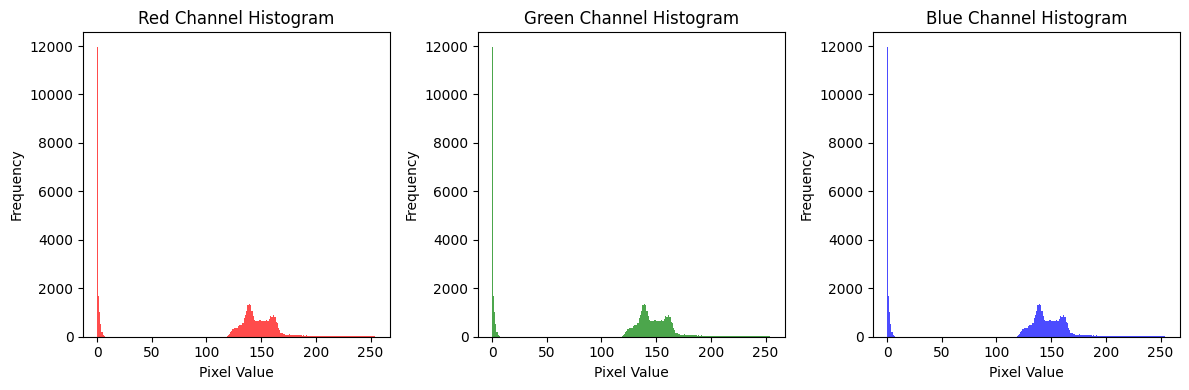

In [5]:
### HISTOGRAM OF PIXEL VALUES
# Set base directory (adjust the path as needed)
base_dir = "/content/drive/MyDrive/LJMU_Research/Dataset_Code_Experiment/train/BLD_Preprocessed_Dataset"
disease_classes = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
sample_class = disease_classes[0]  # choose the first class
sample_img_path = os.path.join(base_dir, sample_class, os.listdir(os.path.join(base_dir, sample_class))[0])
img = np.array(Image.open(sample_img_path))

plt.figure(figsize=(12, 4))
colors = ['red', 'green', 'blue']
for i, color in enumerate(colors):
    plt.subplot(1, 3, i+1)
    plt.hist(img[:, :, i].ravel(), bins=256, color=color, alpha=0.7)
    plt.title(f'{color.capitalize()} Channel Histogram')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

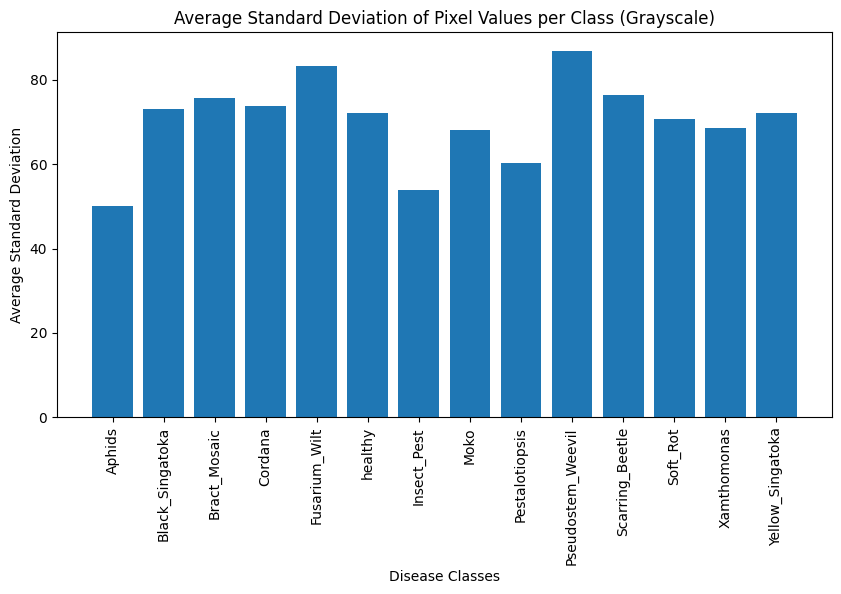

In [6]:
### STD DEVIATION OF PIXEL VALUES PER CLASS

base_dir = "/content/drive/MyDrive/LJMU_Research/Dataset_Code_Experiment/train/BLD_Preprocessed_Dataset"
disease_classes = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
class_std = {}

for disease_class in disease_classes:
    class_path = os.path.join(base_dir, disease_class)
    image_files = os.listdir(class_path)
    if len(image_files) == 0:
        continue
    stds = []
    sample_count = min(5, len(image_files))
    for img_name in image_files[:sample_count]:
        img_path = os.path.join(class_path, img_name)
        # Convert image to grayscale
        img = np.array(Image.open(img_path).convert('L'))
        stds.append(np.std(img))
    class_std[disease_class] = np.mean(stds)

plt.figure(figsize=(10, 5))
plt.bar(list(class_std.keys()), list(class_std.values()))
plt.xticks(rotation=90)
plt.xlabel("Disease Classes")
plt.ylabel("Average Standard Deviation")
plt.title("Average Standard Deviation of Pixel Values per Class (Grayscale)")
plt.show()

In [7]:
## Image Quality Metrics (Contrast, Brightness, and Sharpness)

# Select a sample image from the first class
disease_classes = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
sample_class = disease_classes[0]
sample_img_path = os.path.join(base_dir, sample_class, os.listdir(os.path.join(base_dir, sample_class))[0])
img = cv2.imread(sample_img_path)

# Convert to grayscale for analysis
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Calculate brightness as the mean pixel intensity
brightness = np.mean(gray)

# Calculate contrast as the standard deviation of pixel intensities
contrast = np.std(gray)

# Calculate sharpness using the variance of the Laplacian
sharpness = cv2.Laplacian(gray, cv2.CV_64F).var()

print("Brightness (mean pixel intensity):", brightness)
print("Contrast (std of pixel intensities):", contrast)
print("Sharpness (variance of Laplacian):", sharpness)

Brightness (mean pixel intensity): 104.5814134247449
Contrast (std of pixel intensities): 71.83823169820643
Sharpness (variance of Laplacian): 3777.412813604896


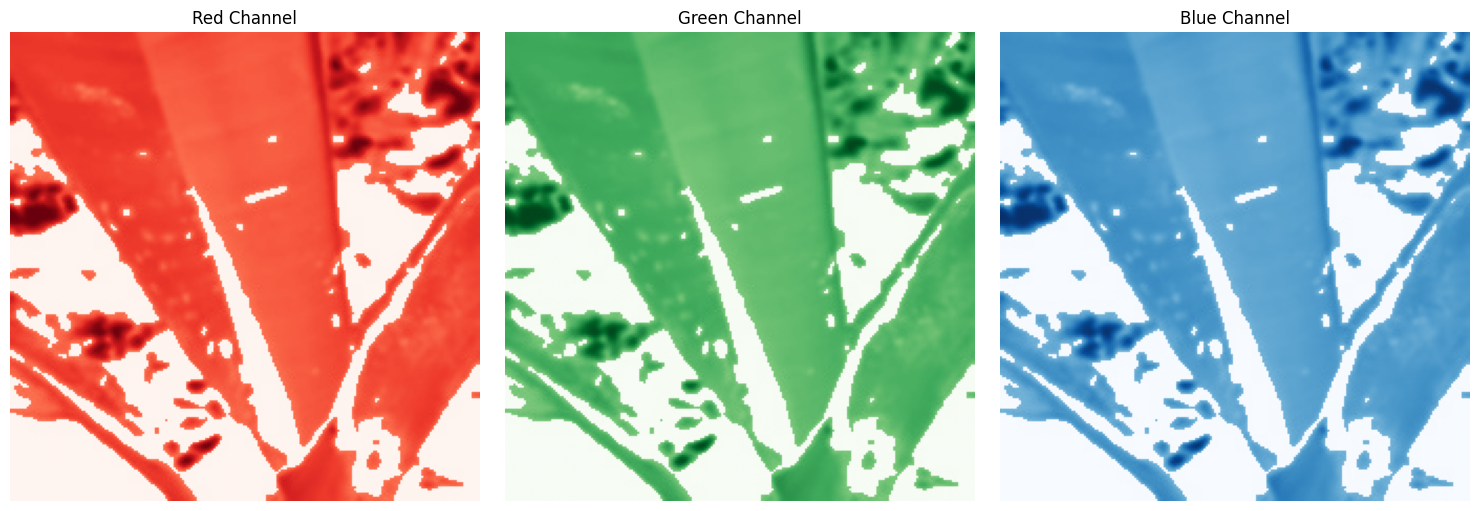

In [8]:
## CHANNEL WISE ANALYSIS

disease_classes = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
sample_class = disease_classes[0]
sample_img_path = os.path.join(base_dir, sample_class, os.listdir(os.path.join(base_dir, sample_class))[0])
img = np.array(Image.open(sample_img_path))

# Extract individual channels
red_channel = img[:, :, 0]
green_channel = img[:, :, 1]
blue_channel = img[:, :, 2]

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(red_channel, cmap='Reds')
plt.title("Red Channel")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(green_channel, cmap='Greens')
plt.title("Green Channel")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(blue_channel, cmap='Blues')
plt.title("Blue Channel")
plt.axis("off")

plt.tight_layout()
plt.show()

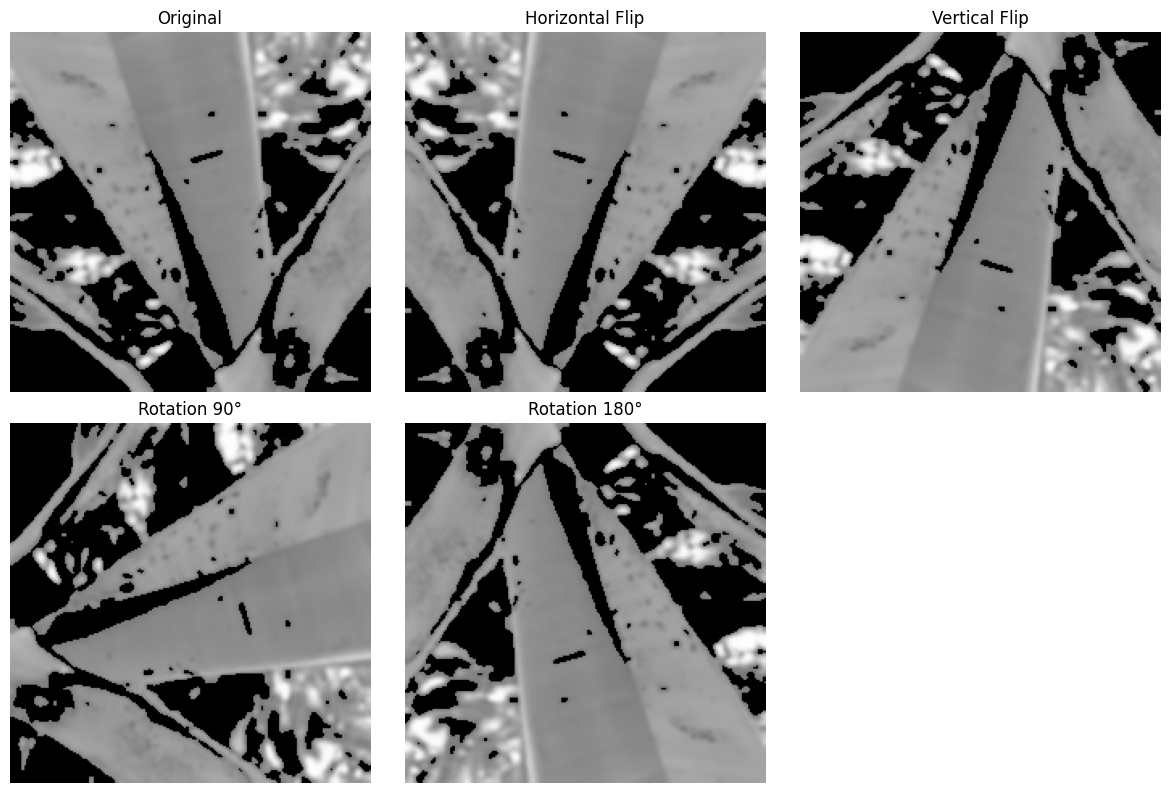

In [9]:
## DATA Augmentation Visualization

# Select a sample image from the dataset
disease_classes = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
sample_class = disease_classes[0]
sample_img_path = os.path.join(base_dir, sample_class, os.listdir(os.path.join(base_dir, sample_class))[0])
img = cv2.imread(sample_img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for display

# Apply augmentations:
hflip = cv2.flip(img, 1)             # Horizontal flip
vflip = cv2.flip(img, 0)             # Vertical flip
rot90 = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)  # Rotate 90 degrees
rot180 = cv2.rotate(img, cv2.ROTATE_180)           # Rotate 180 degrees

plt.figure(figsize=(12, 8))

plt.subplot(2, 3, 1)
plt.imshow(img)
plt.title("Original")
plt.axis("off")

plt.subplot(2, 3, 2)
plt.imshow(hflip)
plt.title("Horizontal Flip")
plt.axis("off")

plt.subplot(2, 3, 3)
plt.imshow(vflip)
plt.title("Vertical Flip")
plt.axis("off")

plt.subplot(2, 3, 4)
plt.imshow(rot90)
plt.title("Rotation 90°")
plt.axis("off")

plt.subplot(2, 3, 5)
plt.imshow(rot180)
plt.title("Rotation 180°")
plt.axis("off")

plt.tight_layout()
plt.show()

## Model 1: Random Forest (Base Model)

In [3]:
# 2. Define dataset path (update as per your folder structure on Google Drive)
dataset_path = "/content/drive/MyDrive/LJMU_Research/Dataset_Code_Experiment/train/BLD_Resized_Dataset"

# 3. Load images & labels
X = []  # Features
y = []  # Labels
labels_dict = {}  # Map folder names to numeric labels
label_counter = 0

for folder in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, folder)
    if os.path.isdir(folder_path):
        if folder not in labels_dict:
            labels_dict[folder] = label_counter
            label_counter += 1
        label = labels_dict[folder]

        for img_name in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)
            if img is None:
                continue  # Skip unreadable images
            img = cv2.resize(img, (224, 224))  # Ensure correct size
            img = img.flatten()  # Convert to 1D feature vector
            X.append(img)
            y.append(label)

# Convert lists to NumPy arrays
X = np.array(X)
y = np.array(y)

# 4. Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. Train Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# 6. Predictions
y_pred = rf_model.predict(X_test)

# 7. Compute metrics
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# For mAP, binarize labels
n_classes = label_counter
y_test_bin = label_binarize(y_test, classes=range(n_classes))
y_scores = rf_model.predict_proba(X_test)
mAP = average_precision_score(y_test_bin, y_scores, average='macro')

print(f"Random Forest Accuracy: {accuracy * 100:.2f}%")
print(f"Recall (macro): {recall * 100:.2f}%")
print(f"F1-score (macro): {f1 * 100:.2f}%")
print(f"Mean Average Precision (mAP): {mAP * 100:.2f}%")

# 8. Save the model to Google Drive
model_save_path = "/content/drive/MyDrive/LJMU_Research/Model/random_forest_model.pkl"
joblib.dump(rf_model, model_save_path)
print(f"Model saved at: {model_save_path}")

Random Forest Accuracy: 75.80%
Recall (macro): 76.48%
F1-score (macro): 76.05%
Mean Average Precision (mAP): 78.72%
Model saved at: /content/drive/MyDrive/LJMU_Research/Model/random_forest_model.pkl


## GLCM AND NGTDM FEATURE EXTRACTION

In [7]:
## GLCM FEATURE EXTRACTION
def extract_glcm_features(image):
    distances = [1, 2, 3]  # Distances for co-occurrence matrix
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]  # Angles to consider
    glcm = graycomatrix(image, distances=distances, angles=angles, levels=256, symmetric=True, normed=True)

    features = []
    for prop in ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']:
        features.extend(graycoprops(glcm, prop).flatten())

    return features

## NGTDM FEATURE EXTRACTION
def extract_ngtdm_features(image):
    try:
        # Compute Haralick texture features and take the mean across different directions
        ngtdm = mahotas.features.haralick(image).mean(axis=0)
    except Exception as e:
        print("Error in NGTDM feature extraction:", e)
        ngtdm = np.zeros(13)  # Return zero features if error occurs

    return ngtdm.tolist()

In [8]:
# Set the dataset path from Google Drive (update the path as necessary)
dataset_path = "/content/drive/MyDrive/LJMU_Research/Dataset_Code_Experiment/train/BLD_Resized_Dataset"
classes = sorted(os.listdir(dataset_path))  # List of disease classes

X = []  # Feature matrix
y = []  # Labels

for class_index, class_name in enumerate(classes):
    class_path = os.path.join(dataset_path, class_name)

    if not os.path.isdir(class_path):
        continue  # Skip non-folder files

    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)

        try:
            # Read the image in grayscale and resize to 224x224
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                print(f"Image {img_name} in {class_name} could not be read.")
                continue
            img = cv2.resize(img, (224, 224))

            # Extract GLCM and NGTDM features
            glcm_features = extract_glcm_features(img)
            ngtdm_features = extract_ngtdm_features(img)

            # Combine both feature sets into one feature vector
            features = glcm_features + ngtdm_features
            X.append(features)
            y.append(class_index)

        except Exception as e:
            print(f"Skipping image {img_name}: {e}")

# Convert lists to NumPy arrays
X = np.array(X)
y = np.array(y)

# Save the features and labels for future use
np.save("features.npy", X)
np.save("labels.npy", y)

print("Feature extraction complete! Features saved as 'features.npy' and labels saved as 'labels.npy'.")

Feature extraction complete! Features saved as 'features.npy' and labels saved as 'labels.npy'.


In [6]:
# Load extracted features and labels from your Google Drive location
features_path = "/content/drive/MyDrive/LJMU_Research/Dataset_Code_Experiment/features.npy"
labels_path = "/content/drive/MyDrive/LJMU_Research/Dataset_Code_Experiment/labels.npy"

X = np.load(features_path)
y = np.load(labels_path)

# Split data (80% train, 20% test) with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Feature scaling (SVM performs better with normalized features)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define function to train and evaluate SVM
def train_evaluate_svm(X_train, X_test, y_train, y_test, feature_set_name):
    print(f"\n🔹 Training SVM with {feature_set_name} Features...")

    model = SVC(kernel='linear', probability=True, random_state=42)
    model.fit(X_train, y_train)

    # Make predictions and obtain probabilities
    y_pred = model.predict(X_test)

    # For binary classification, extract column 1; if multi-class, use full probability matrix
    if len(np.unique(y_train)) == 2:
        y_probs = model.predict_proba(X_test)[:, 1]
    else:
        y_probs = model.predict_proba(X_test)

    # Evaluation Metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')

    if len(np.unique(y_train)) == 2:
        auc_roc = roc_auc_score(y_test, y_probs)
        mAP = average_precision_score(y_test, y_probs)
    else:
        # For multi-class, binarize labels and use 'ovr' approach
        n_classes = len(np.unique(y_train))
        y_test_bin = label_binarize(y_test, classes=range(n_classes))
        auc_roc = roc_auc_score(y_test_bin, y_probs, multi_class='ovr')
        mAP = average_precision_score(y_test_bin, y_probs, average='macro')

    print(f"Accuracy: {accuracy:.4f}")
    print(f"mAP: {mAP:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"AUC-ROC: {auc_roc:.4f}")

    # Save the model to Google Drive
    model_save_path = f"/content/drive/MyDrive/LJMU_Research/Model/SVM_{feature_set_name}.pkl"
    with open(model_save_path, "wb") as f:
        pickle.dump(model, f)
    print(f"Model saved as {model_save_path}")

# Train and evaluate the SVM with scaled features, e.g., using "GLCM_NGTDM" as the feature set name
train_evaluate_svm(X_train_scaled, X_test_scaled, y_train, y_test, "GLCM_NGTDM")


🔹 Training SVM with GLCM_NGTDM Features...
Accuracy: 0.7329
mAP: 0.7741
F1-score: 0.7281
Recall: 0.7329
AUC-ROC: 0.9714
Model saved as /content/drive/MyDrive/LJMU_Research/Model/SVM_GLCM_NGTDM.pkl


In [ ]:
# Extract GLCM Features Only (Assuming first half of X are GLCM features)
glcm_features = X[:, :X.shape[1] // 2]

# Apply PCA to reduce the number of features (e.g., to 50 principal components)
pca = PCA(n_components=50, random_state=42)
glcm_features_reduced = pca.fit_transform(glcm_features)

# Split the reduced GLCM features into training and testing sets using train_test_split
X_train_glcm, X_test_glcm, y_train_glcm, y_test_glcm = train_test_split(
    glcm_features_reduced, y, test_size=0.2, random_state=42, stratify=y
)

# Train and evaluate SVM with the reduced GLCM features
train_evaluate_svm(X_train_glcm, X_test_glcm, y_train_glcm, y_test_glcm, "GLCM_PCA")

In [ ]:
# Extract GLCM Features Only
# Assuming that the first half of the feature vector corresponds to GLCM features
glcm_features = X[:, :X.shape[1] // 2]

# Split the GLCM features into training and testing sets
X_train_glcm = glcm_features[:len(X_train)]
X_test_glcm = glcm_features[len(X_train):]

# Train and evaluate SVM with GLCM features
train_evaluate_svm(X_train_glcm, X_test_glcm, y_train, y_test, "GLCM")


🔹 Training SVM with GLCM Features...


In [ ]:
# Extract NGTDM Features Only
# Assuming that the second half of the feature vector corresponds to NGTDM features
ngtdm_features = X[:, X.shape[1] // 2:]

# Split the NGTDM features into training and testing sets
X_train_ngtdm = ngtdm_features[:len(X_train)]
X_test_ngtdm = ngtdm_features[len(X_train):]

# Train and evaluate SVM with NGTDM features
train_evaluate_svm(X_train_ngtdm, X_test_ngtdm, y_train, y_test, "NGTDM")